In [ ]:
!pip install tensorflow

C:\Users\Muthukumar\AppData\Local\Temp\ipykernel_10256\3348235977.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Fill missing values


Random Forest MAE: 366.30438356164376, RMSE: 436.6892268496846
Epoch 1/20
19/19 [==============================] - 2s 2ms/step - loss: 0.3084
Epoch 2/20
19/19 [==============================] - 0s 2ms/step - loss: 0.2182
Epoch 3/20
19/19 [==============================] - 0s 2ms/step - loss: 0.1180
Epoch 4/20
19/19 [==============================] - 0s 2ms/step - loss: 0.0944
Epoch 5/20
19/19 [==============================] - 0s 2ms/step - loss: 0.0923
Epoch 6/20
19/19 [==============================] - 0s 2ms/step - loss: 0.0901
Epoch 7/20
19/19 [==============================] - 0s 2ms/step - loss: 0.0883
Epoch 8/20
19/19 [==============================] - 0s 2ms/step - loss: 0.0873
Epoch 9/20
19/19 [==============================] - 0s 2ms/step - loss: 0.0871
Epoch 10/20
19/19 [==============================] - 0s 2ms/step - loss: 0.0864
Epoch 11/20
19/19 [==============================] - 0s 2ms/step - loss: 0.0854
Epoch 12/20
19/19 [==============================] - 0s 2ms/step -

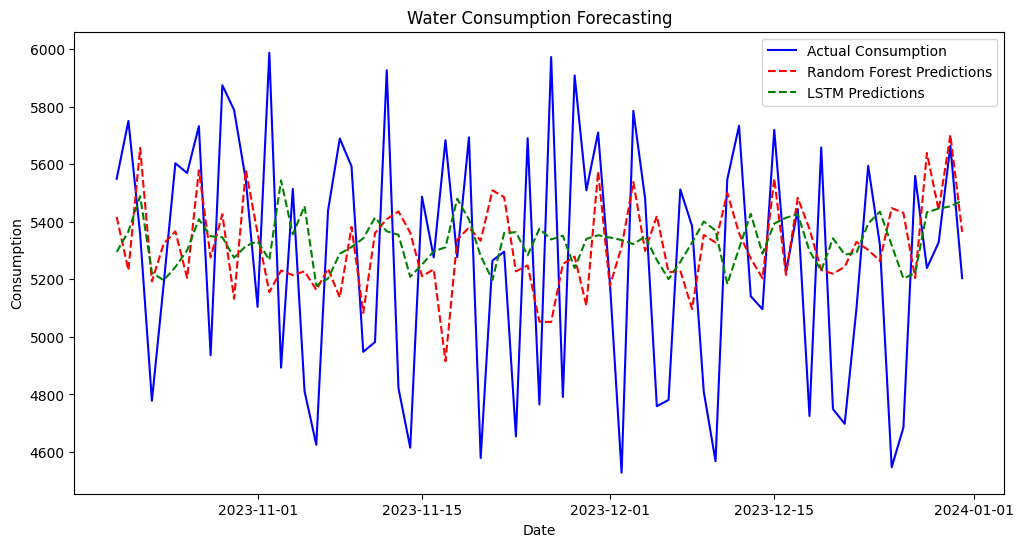

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load dataset (Replace with actual water consumption dataset)
df = pd.read_csv('water_usage.csv', parse_dates=['date'], index_col='date')
# Ensure the index is a DatetimeIndex
# The original line assumed the format was MM-DD-YYYY.
# We're specifying the correct format DD-MM-YYYY.
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')  # Convert index to DatetimeIndex
df = df.resample('D').mean()  # Resample to daily data if needed
df.fillna(method='ffill', inplace=True)  # Fill missing values

# Feature Engineering
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year
df['lag_1'] = df['consumption'].shift(1)  # Previous day's usage
df.dropna(inplace=True)  # Drop NaN values caused by shifting

# ... (rest of the code remains the same)
# Splitting dataset
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train = train.drop(columns=['consumption'])
y_train = train['consumption']
X_test = test.drop(columns=['consumption'])
y_test = test['consumption']

# Normalize Data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)

# Evaluate Random Forest Model
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
print(f"Random Forest MAE: {rf_mae}, RMSE: {rf_rmse}")

# Prepare Data for LSTM
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Model 2: LSTM Neural Network
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_scaled, epochs=20, batch_size=16, verbose=1)

# Predictions using LSTM
lstm_preds_scaled = lstm_model.predict(X_test_lstm)
lstm_preds = scaler_y.inverse_transform(lstm_preds_scaled)

# Evaluate LSTM Model
lstm_mae = mean_absolute_error(y_test, lstm_preds)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_preds))
print(f"LSTM MAE: {lstm_mae}, RMSE: {lstm_rmse}")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual Consumption', color='blue')
plt.plot(test.index, rf_preds, label='Random Forest Predictions', color='red', linestyle='dashed')
plt.plot(test.index, lstm_preds, label='LSTM Predictions', color='green', linestyle='dashed')
plt.legend()
plt.title("Water Consumption Forecasting")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.show()
